In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from scipy import interp
from itertools import cycle
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
wine_fileName = "wine.csv"
wine_col_names = ['Class','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols',
            'Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity',
            'Hue','OD280/OD315 of diluted wines','Proline']
classes = ['Class1','Class2','Class3']
attrib_discard = ['Ash','Magnesium']
#testSize = np.arange(0.01,1,0.5)
testSize = [0.1,0.5,0.75,0.8,0.95]
classifiers = [("Logistic Regression",LogisticRegression(multi_class='multinomial', 
                                                solver='newton-cg', class_weight='balanced')),
               ("SGD",SGDClassifier(loss='log')),
               ("Naive Bayes",MultinomialNB()),
               ("Linear Discriminant Analysis",LinearDiscriminantAnalysis()),
               ("Random Forest",RandomForestClassifier(class_weight='balanced',random_state=42)),
               
              ]


Accuracy_Dictionary = {}

In [3]:
wine_dataset = pd.read_csv(wine_fileName,header=None, names = wine_col_names)
wine_dataset.drop(labels = attrib_discard, inplace=True,axis=1)

X = wine_dataset.iloc[:,1:].values
y = wine_dataset.iloc[:,0:1].values.flatten()

#wine_col_names will be treated as feature list. So target variable name will be removed now.
wine_col_names.remove('Class')

In [4]:
#Normalize data.
scaler = MinMaxScaler(feature_range = (0,1))
X = scaler.fit_transform(X)

In [5]:
#TrainTest Split - 70:30
X_train,X_test,Y_train,Y_test = train_test_split(X,y, stratify=y, train_size = 0.7,
                                                random_state = 42)


In [7]:
  
def compute_metrics(classifier, predictions, Y_test):
   
    print("Metrics for ",classifier)
    #Y_classes = [np.argmax(item) for item in Y_test]
    #predicted_classes = [np.argmax(item) for item in predicted]
    
    #predictions = np.array(predicted_classes)
    #Y_actual = np.array(Y_classes)
    print("Test Accuracy : ", metrics.accuracy_score(Y_test, predictions))
    #print("Test error : ",log_loss(Y_test,predictions,labels=[1,2,3]))
   
    y_actu = pd.Series(np.reshape(Y_test,len(Y_test)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=[1,2,3])
    y_pre = pd.Categorical(y_pred, categories=[1,2,3])
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_test, predictions, average='weighted', labels = [1,2,3])))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    #predicted= np.array(predictions).tolist()
    #Y_test = np.array(Y_actual).tolist()

    #Need to one hot encode for computing ROC
    n_classes = 3
    onh = OneHotEncoder()
    Y_test = Y_test.reshape((len(Y_test),1))
    predictions = predictions.reshape((len(predictions),1))
    Y_test = onh.fit_transform(Y_test).toarray()
    predictions = onh.fit_transform(predictions).toarray()
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


/Users/ass6ash/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Metrics for  Logistic Regression
Test Accuracy :  0.962962962963
Average F1 score is 0.9629629629629629
Confusion matrix: 
 Predicted   1   2   3
Actual               
1          17   1   0
2           1  20   0
3           0   0  15


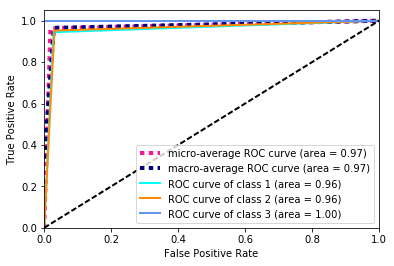



Metrics for  SGD
Test Accuracy :  0.962962962963
Average F1 score is 0.9629629629629629
Confusion matrix: 
 Predicted   1   2   3
Actual               
1          17   1   0
2           1  20   0
3           0   0  15


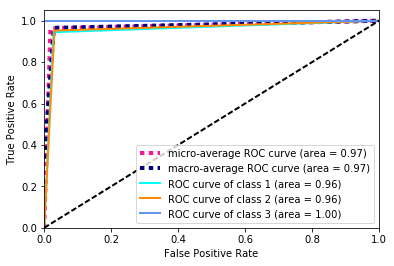



Metrics for  Naive Bayes
Test Accuracy :  0.962962962963
Average F1 score is 0.9629629629629629
Confusion matrix: 
 Predicted   1   2   3
Actual               
1          17   1   0
2           1  20   0
3           0   0  15


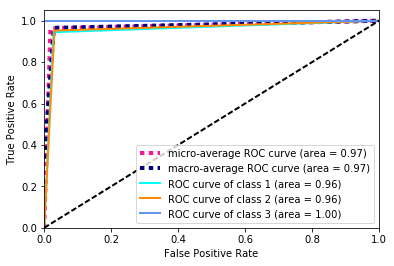



Metrics for  Linear Discriminant Analysis
Test Accuracy :  0.962962962963
Average F1 score is 0.9629629629629629
Confusion matrix: 
 Predicted   1   2   3
Actual               
1          17   1   0
2           1  20   0
3           0   0  15


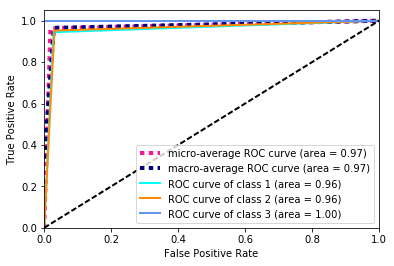



Metrics for  Random Forest
Test Accuracy :  0.962962962963
Average F1 score is 0.9629629629629629
Confusion matrix: 
 Predicted   1   2   3
Actual               
1          17   1   0
2           1  20   0
3           0   0  15


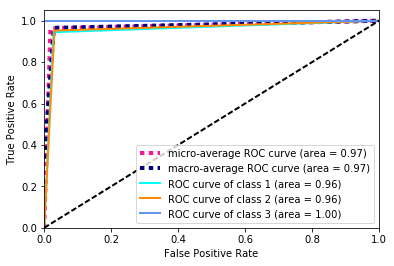

In [8]:
#Time for training

for name,classifier in classifiers:
    accuracies=[]
    for size in testSize:
        X_train,X_test,Y_train,Y_test = train_test_split(X,y, stratify=y, test_size = size,
                                                    random_state = 42)
        classifier.fit(X_train, Y_train)
        predictions = classifier.predict(X_test)
        accuracies.append(metrics.accuracy_score(Y_test, predictions))
    Accuracy_Dictionary[name] = accuracies
    
#Generate metrics for all classifiers with 70:30 ratio
X_train,X_test,Y_train,Y_test = train_test_split(X,y, stratify=y, test_size = 0.3,
                                                    random_state = 42)

for name,classifer in classifiers:    
    classifier.fit(X_train, Y_train)
    predictions = classifier.predict(X_test)
    compute_metrics(name,predictions,Y_test)
    print("\n====================================\n")



In [11]:
Accuracy_Dictionary

{'Linear Discriminant Analysis': [0.94444444444444442,
  0.97752808988764039,
  0.94776119402985071,
  0.94405594405594406,
  0.81176470588235294],
 'Logistic Regression': [1.0,
  0.9550561797752809,
  0.95522388059701491,
  0.97202797202797198,
  0.90588235294117647],
 'Naive Bayes': [0.88888888888888884,
  0.9101123595505618,
  0.94776119402985071,
  0.95104895104895104,
  0.81176470588235294],
 'Random Forest': [1.0,
  0.9662921348314607,
  0.90298507462686572,
  0.92307692307692313,
  0.88823529411764701],
 'SGD': [0.94444444444444442,
  0.9213483146067416,
  0.92537313432835822,
  0.93706293706293708,
  0.8529411764705882]}

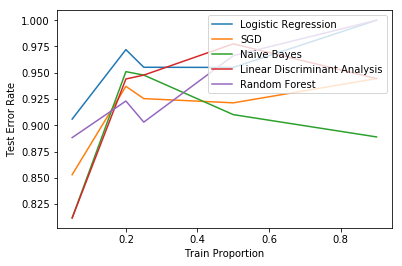

In [13]:
for name,classifier in classifiers:
    plt.plot(1-np.array(testSize),Accuracy_Dictionary.get(name),label=name)
plt.legend(loc="lower right")
plt.xlabel("Train Proportion")
plt.ylabel("Test Error Rate")
plt.show()

In [ ]:
(predictions == Y_test)